In [58]:
#### article picked from:
###  https://medium.com/the-ai-forum/build-a-reliable-rag-agent-using-langgraph-2694d55995cd

In [4]:
! pip install -U langchain-nomic langchain_community tiktoken langchainhub chromadb langchain langgraph tavily-python gpt4all fastembed langchain-groq

In [1]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings.fastembed import FastEmbedEmbeddings

In [2]:
embed_model = FastEmbedEmbeddings(model_name="BAAI/bge-base-en-v1.5")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

model_optimized.onnx:   0%|          | 0.00/218M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/740 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

In [3]:
from groq import Groq
from langchain_groq import ChatGroq
from langchain.schema import BaseMessage, HumanMessage

# Directly pass the API key
llm = ChatGroq(temperature=0,
               model_name="Llama3-8b-8192",
               api_key="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")

# Pass input as a HumanMessage (or format as needed)
message = HumanMessage(content="Hello, how are you?")

# Get the response
response = llm([message])
print(response)


<ipython-input-3-74329bb3a367>:14: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = llm([message])


content="I'm just a language model, I don't have emotions or feelings like humans do, but I'm functioning properly and ready to help you with any questions or tasks you may have! How can I assist you today?" additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 45, 'prompt_tokens': 16, 'total_tokens': 61, 'completion_time': 0.0375, 'prompt_time': 0.00241621, 'queue_time': 0.02010251, 'total_time': 0.03991621}, 'model_name': 'Llama3-8b-8192', 'system_fingerprint': 'fp_dadc9d6142', 'finish_reason': 'stop', 'logprobs': None} id='run-17338105-0be1-4eac-861b-f45d38becfb4-0' usage_metadata={'input_tokens': 16, 'output_tokens': 45, 'total_tokens': 61}


In [5]:
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]
print(f"len of documents :{len(docs_list)}")

len of documents :3


In [6]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=512, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)
print(f"length of document chunks generated :{len(doc_splits)}")

length of document chunks generated :87


In [7]:
vectorstore = Chroma.from_documents(documents=doc_splits,
                                    embedding=embed_model,
                                    collection_name="local-rag")

In [14]:
retriever = vectorstore.as_retriever(search_kwargs={"k":2})

In [8]:
import time
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.output_parsers import StrOutputParser

prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are an expert at routing a
    user question to a vectorstore or web search. Use the vectorstore for questions on LLM  agents,
    prompt engineering, and adversarial attacks. You do not need to be stringent with the keywords
    in the question related to these topics. Otherwise, use web-search. Give a binary choice 'web_search'
    or 'vectorstore' based on the question. Return the a JSON with a single key 'datasource' and
    no premable or explaination. Question to route: {question} <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["question"],
)
start = time.time()
question_router = prompt | llm | JsonOutputParser()
#
question = "llm agent memory"
print(question_router.invoke({"question": question}))
end = time.time()
print(f"The time required to generate response by Router Chain in seconds:{end - start}")


{'datasource': 'vectorstore'}
The time required to generate response by Router Chain in seconds:0.2792346477508545


In [9]:
## Implement the Generate chain

In [10]:
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are an assistant for question-answering tasks.
    Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know.
    Use three sentences maximum and keep the answer concise <|eot_id|><|start_header_id|>user<|end_header_id|>
    Question: {question}
    Context: {context}
    Answer: <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["question", "document"],
)

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Chain
start = time.time()
rag_chain = prompt | llm | StrOutputParser()

In [11]:
## Implement the Retrieval Grader

In [15]:
#
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing relevance
    of a retrieved document to a user question. If the document contains keywords related to the user question,
    grade it as relevant. It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explaination.
     <|eot_id|><|start_header_id|>user<|end_header_id|>
    Here is the retrieved document: \n\n {document} \n\n
    Here is the user question: {question} \n <|eot_id|><|start_header_id|>assistant<|end_header_id|>
    """,
    input_variables=["question", "document"],
)
start = time.time()
retrieval_grader = prompt | llm | JsonOutputParser()
question = "agent memory"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))
end = time.time()
print(f"The time required to generate response by the retrieval grader in seconds:{end - start}")


{'score': 'yes'}
The time required to generate response by the retrieval grader in seconds:0.42793750762939453


In [16]:
## hallucination grader

In [19]:
import time
from transformers import pipeline
from langchain.prompts import PromptTemplate
import json

# Initialize the generation text (This is the answer you want to assess)
generation = "This is the generated answer text."

# Initialize the documents (example list of documents)
docs = [
    "Fact 1: The sky is blue.",
    "Fact 2: Water boils at 100°C.",
]

# Define the prompt template
prompt = PromptTemplate(
    template=""" <|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing whether
    an answer is grounded in / supported by a set of facts. Give a binary 'yes' or 'no' score to indicate
    whether the answer is grounded in / supported by a set of facts. Provide the binary score as a JSON with a
    single key 'score' and no preamble or explanation. <|eot_id|><|start_header_id|>user<|end_header_id|>
    Here are the facts:
    \n ------- \n
    {documents}
    \n ------- \n
    Here is the answer: {generation}  <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["generation", "documents"],
)

# Use Hugging Face model for text generation
llm = pipeline("text-generation", model="gpt2", max_new_tokens=50)  # Set max_new_tokens to 50

# Custom output parser to parse JSON output
class JsonOutputParser:
    def parse(self, output: str) -> dict:
        try:
            return json.loads(output)  # Convert output to a dictionary (assumes valid JSON response)
        except json.JSONDecodeError:
            print("Error decoding JSON from the output")
            return {}

# Instantiate the custom output parser
output_parser = JsonOutputParser()

# Start the timer
start = time.time()

# Define a simple function to handle the entire process
def hallucination_grader_chain(documents, generation):
    # Format the prompt with documents and generation
    formatted_prompt = prompt.format(documents=documents, generation=generation)

    # Use the LLM to generate a response
    raw_response = llm(formatted_prompt)[0]['generated_text']  # Get the generated text

    # Parse the output using JsonOutputParser
    parsed_response = output_parser.parse(raw_response)

    return parsed_response

# Generate the response
hallucination_grader_response = hallucination_grader_chain(docs, generation)

# End the timer
end = time.time()

# Print the time and response
print(f"The time required to generate response by the generation chain in seconds: {end - start}")
print(hallucination_grader_response)


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Error decoding JSON from the output
The time required to generate response by the generation chain in seconds: 3.1540369987487793
{}


In [18]:
## Answer Grader

In [24]:
import time
from transformers import pipeline
from langchain.prompts import PromptTemplate
import json

# Initialize the generation text (This is the answer you want to assess)
generation = "This is the generated answer text."

# Initialize the question (this is the question you want to evaluate the answer for)
question = "What is the color of the sky?"

# Define the prompt template for answer grading
answer_grader_prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing whether the
    answer is useful to resolve a question. Give a binary score 'yes' or 'no' to indicate whether the answer is
    useful to resolve a question. Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.
     <|eot_id|><|start_header_id|>user<|end_header_id|> Here is the answer:
    \n ------- \n
    {generation}
    \n ------- \n
    Here is the question: {question} <|eot_id|><|start_header_id|>"""
    ,
    input_variables=["generation", "question"],
)

# Initialize the Hugging Face text generation pipeline
llm = pipeline("text-generation", model="gpt2", max_new_tokens=50)  # Set max_new_tokens to 50

# Custom output parser to parse JSON output
class JsonOutputParser:
    def parse(self, output: str) -> dict:
        try:
            return json.loads(output)  # Convert output to a dictionary (assumes valid JSON response)
        except json.JSONDecodeError:
            print("Error decoding JSON from the output")
            return {}

# Instantiate the custom output parser
output_parser = JsonOutputParser()

# Start the timer
start = time.time()

# Define a simple function to handle the entire process for grading
def answer_grader_chain(question, generation):
    """
    This function evaluates whether a generated answer is useful for resolving the question.
    It uses a pre-defined prompt to generate a score ("yes" or "no").
    """
    # Format the prompt with the input question and generation
    formatted_prompt = answer_grader_prompt.format(question=question, generation=generation)

    # Use the LLM (Hugging Face pipeline) to generate a response
    raw_response = llm(formatted_prompt)[0]['generated_text']  # Get the generated text

    # Parse the output using JsonOutputParser
    parsed_response = output_parser.parse(raw_response)

    return parsed_response

# Generate the response and evaluate the answer
answer_grader_response = answer_grader_chain(question, generation)

# End the timer
end = time.time()

# Print the time taken and the response
print(f"The time required to generate response by the answer grader in seconds: {end - start}")
print("Answer grader response:", answer_grader_response)


Device set to use cpu
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Error decoding JSON from the output
The time required to generate response by the answer grader in seconds: 4.510826110839844
Answer grader response: {}


In [45]:
import time
from transformers import pipeline
from langchain.prompts import PromptTemplate
import json

# Initialize the generation text (This is the answer you want to assess)
generation = "This is the generated answer text."

# Initialize the question (this is the question you want to evaluate the answer for)
question = "What is the color of the sky?"

# Define the prompt template for answer grading
answer_grader_prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing whether the
    answer is useful to resolve a question. Give a binary score 'yes' or 'no' to indicate whether the answer is
    useful to resolve a question. Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.
     <|eot_id|><|start_header_id|>user<|end_header_id|> Here is the answer:
    \n ------- \n
    {generation}
    \n ------- \n
    Here is the question: {question} <|eot_id|><|start_header_id|>"""
    ,
    input_variables=["generation", "question"],
)

# Initialize the Hugging Face text generation pipeline
llm = pipeline("text-generation", model="gpt2", max_new_tokens=50)  # Set max_new_tokens to 50

# Custom function to handle Hugging Face text generation
def generate_text(prompt):
    generated_output = llm(prompt)
    return {"generated_text": generated_output[0]["generated_text"]}

# Custom output parser to parse JSON output
def parse_json(output: str) -> dict:
    try:
        # Attempt to parse the output as JSON (expecting {"score": "yes"/"no"})
        parsed_output = json.loads(output)
        return parsed_output
    except json.JSONDecodeError:
        # If parsing fails, handle the text-based format (attempt to extract score)
        print("Error decoding JSON, attempting to extract score from text output...")
        return {"score": "no"}  # Default to "no" if JSON parsing fails, could refine this logic

# Start the timer
start = time.time()

# Define a simple function to handle the entire process for grading
def answer_grader_chain(question, generation):
    """
    This function evaluates whether a generated answer is useful for resolving the question.
    It uses a pre-defined prompt to generate a score ("yes" or "no").
    """
    # Format the prompt with the input question and generation
    formatted_prompt = answer_grader_prompt.format(question=question, generation=generation)

    # Use the LLM (Hugging Face pipeline) to generate a response
    raw_response = generate_text(formatted_prompt)["generated_text"]  # Get the generated text

    # Parse the output using the JSON parser
    parsed_response = parse_json(raw_response)

    return parsed_response

# Generate the response and evaluate the answer
answer_grader_response = answer_grader_chain(question, generation)

# End the timer
end = time.time()

# Print the time taken and the response
print(f"The time required to generate response by the answer grader in seconds: {end - start}")
print("Answer grader response:", answer_grader_response)


Device set to use cpu
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Error decoding JSON, attempting to extract score from text output...
The time required to generate response by the answer grader in seconds: 4.544068098068237
Answer grader response: {'score': 'no'}


In [57]:
## Implement Web Search tool

In [53]:
import os
from langchain_community.tools.tavily_search import TavilySearchResults
os.environ['TAVILY_API_KEY'] = "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"
web_search_tool = TavilySearchResults(k=3)

from typing_extensions import TypedDict
from typing import List

### State

class GraphState(TypedDict):
    question: str
    generation: str
    web_search: str
    documents: List[str]

from langchain.schema import Document

def retrieve(state):
    """
    Retrieve documents from vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

def generate(state):
    """
    Generate answer using RAG on retrieved documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}

def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = retrieval_grader.invoke({"question": question, "document": d.page_content})
        grade = score['score']
        # Document relevant
        if grade.lower() == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        # Document not relevant
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            # We do not include the document in filtered_docs
            # We set a flag to indicate that we want to run web search
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "question": question, "web_search": web_search}

def web_search(state):
    """
    Web search based based on the question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended web results to documents
    """

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    if documents is not None:
        documents.append(web_results)
    else:
        documents = [web_results]
    return {"documents": documents, "question": question}

def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    print(question)
    source = question_router.invoke({"question": question})
    print(source)
    print(source['datasource'])
    if source['datasource'] == 'web_search':
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "websearch"
    elif source['datasource'] == 'vectorstore':
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

def decide_to_generate(state):
    """
    Determines whether to generate an answer, or add web search

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    question = state["question"]
    web_search = state["web_search"]
    filtered_documents = state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---")
        return "websearch"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke({"documents": documents, "generation": generation})
    grade = score['score']

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question,"generation": generation})
        grade = score['score']
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

from langgraph.graph import END, StateGraph
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("websearch", web_search) # web search
workflow.add_node("retrieve", retrieve) # retrieve
workflow.add_node("grade_documents", grade_documents) # grade documents
workflow.add_node("generate", generate) # generate

# Set the Entry Point and End Point
workflow.set_conditional_entry_point(
    route_question,
    {
        "websearch": "websearch",
        "vectorstore": "retrieve",
    },
)

workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "websearch": "websearch",
        "generate": "generate",
    },
)
workflow.add_edge("websearch", "generate")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "websearch",
    },
)
###_______________question 1__________________________
# Compile the workflow
app = workflow.compile()

# Test the workflow
from pprint import pprint
inputs = {"question": "What is prompt engineering?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

###_________________question 2__________________________

app = workflow.compile()

# Test
from pprint import pprint
inputs = {"question": "Who are the Bears expected to draft first in the NFL draft?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])


###____________________question 3____________________
app = workflow.compile()

#
inputs = {"question": "What are the types of agent memory?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])


---ROUTE QUESTION---
What is prompt engineering?
{'datasource': 'vectorstore'}
vectorstore
---ROUTE QUESTION TO RAG---
---RETRIEVE---
'Finished running: retrieve:'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
'Finished running: grade_documents:'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
'Finished running: generate:'
('Prompt engineering, also known as In-Context Prompting, is a method for '
 'communicating with large language models (LLMs) to steer their behavior for '
 'desired outcomes without updating the model weights. It is an empirical '
 'science that aims to achieve alignment and model steerability.')
---ROUTE QUESTION---
Who are the Bears expected to draft first in the NFL draft?
{'datasource': 'vectorstore'}
vectorstore
---ROUTE QUE

In [54]:
## Visualize the Agent / Graph

In [55]:
!apt-get install python3-dev graphviz libgraphviz-dev pkg-config
!pip install pygraphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3-dev is already the newest version (3.10.6-1~22.04.1).
python3-dev set to manually installed.
graphviz is already the newest version (2.42.2-6ubuntu0.1).
The following packages were automatically installed and are no longer required:
  libbz2-dev libpkgconf3 libreadline-dev
Use 'apt autoremove' to remove them.
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libgvc6-plugins-gtk
  librsvg2-common libxdot4
Suggested packages:
  gvfs
The following packages will be REMOVED:
  pkgconf r-base-dev
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4 pkg-config
0 upgraded, 10 newly installed, 2 to remove and 29 not upgraded.
Need to get 2,482 kB of archives.
After this operation, 7,671 kB of add

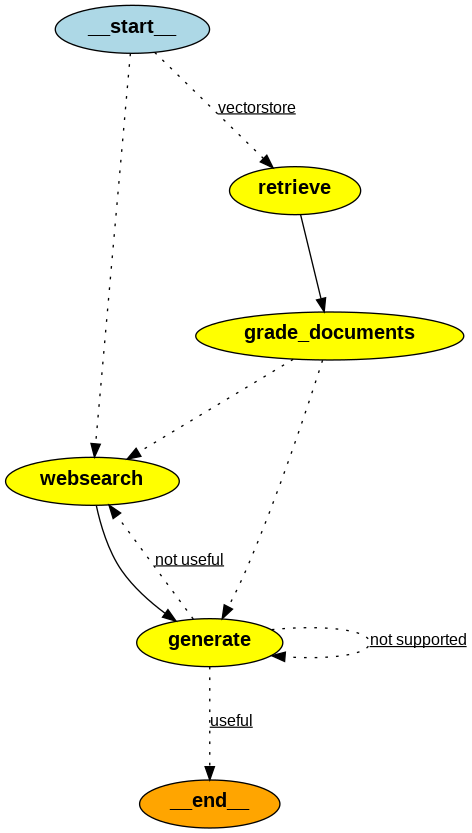

In [56]:
from IPython.display import Image

Image(app.get_graph().draw_png())